# Exploratory Analysis of the Ames dataset

In [1]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import pandas as pd

It is a good idea to define a variable for the base data directory, and to construct the exact filenames from that variable. Another good idea is to use the `pathlib` library for manipulating paths in Python, as it will make your code work in both Windows and Linux/MacOS.

In [2]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

/home/fjayres/Dropbox/Insper/Disciplinas/MachineLearning/2023-1/sandbox/ames/data


## Analyzing the columns individually

Let's load the data from the previous section - this way we don't need to re-run all of the previous data adjusting:

In [3]:
processed_file_path = DATA_DIR / 'processed' / 'ames_with_correct_types.pkl'

with open(processed_file_path, 'rb') as file:
    (
        data,
        continuous_variables,
        discrete_variables,
        ordinal_variables,
        categorical_variables,
    ) = pickle.load(file)


### A first look at the categorical variables

               count unique      top  freq
Misc.Feature     106      5     Shed    95
Alley            198      2     Grvl   120
Garage.Type     2773      6   Attchd  1731
Mas.Vnr.Type    2907      5     None  1752
MS.SubClass     2930     16       20  1079
Central.Air     2930      2        Y  2734
Heating         2930      6     GasA  2885
Foundation      2930      6    PConc  1310
Exterior.2nd    2930     17  VinylSd  1015
Exterior.1st    2930     16  VinylSd  1026
Roof.Matl       2930      8  CompShg  2887
Roof.Style      2930      6    Gable  2321
House.Style     2930      8   1Story  1481
Bldg.Type       2930      5     1Fam  2425
Condition.2     2930      8     Norm  2900
Condition.1     2930      9     Norm  2522
Neighborhood    2930     28    NAmes   443
Lot.Config      2930      5   Inside  2140
Land.Contour    2930      4      Lvl  2633
Street          2930      2     Pave  2918
MS.Zoning       2930      7       RL  2273
Sale.Type       2930     10      WD   2536
Sale.Condit

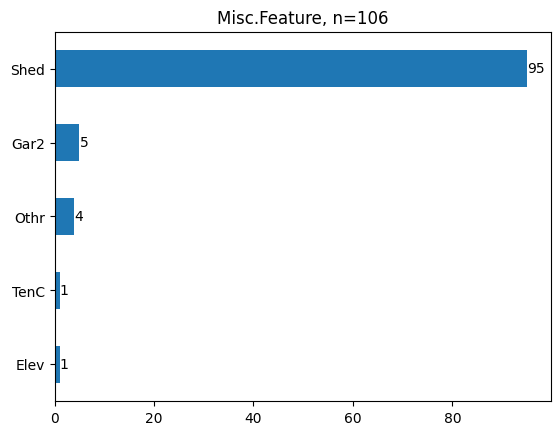

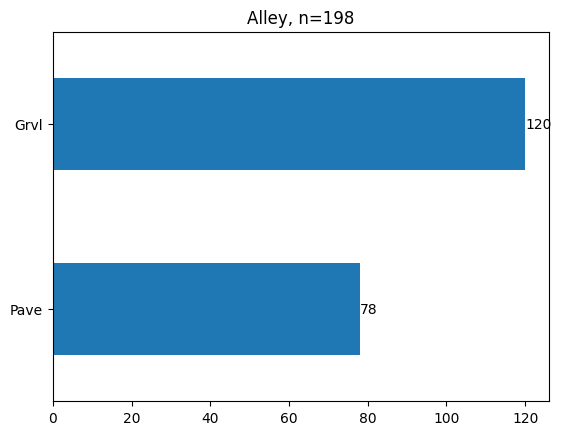

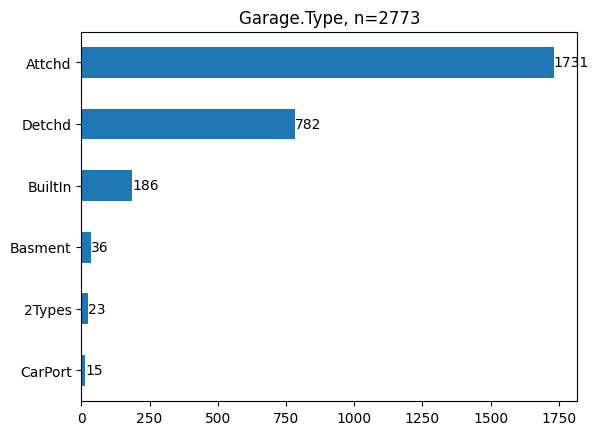

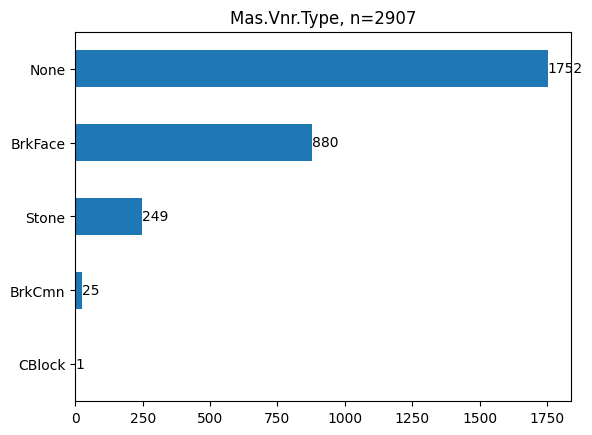

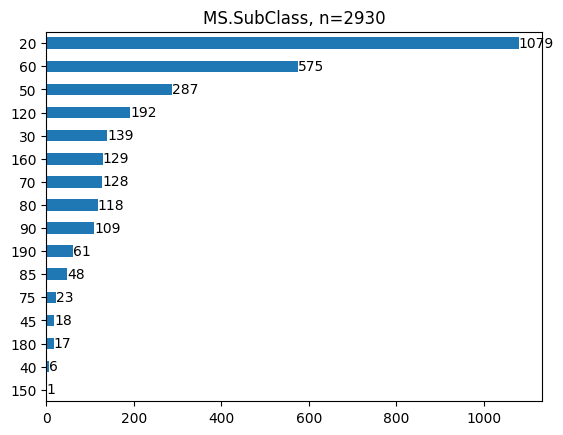

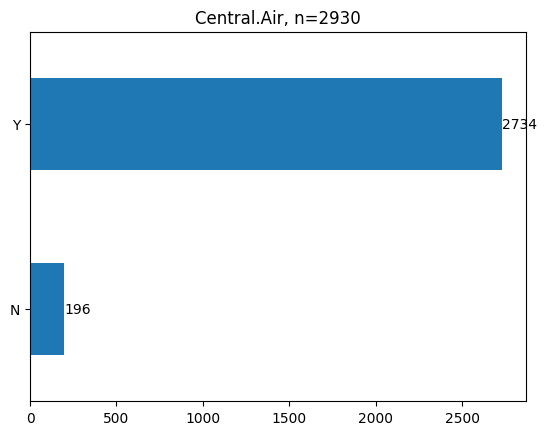

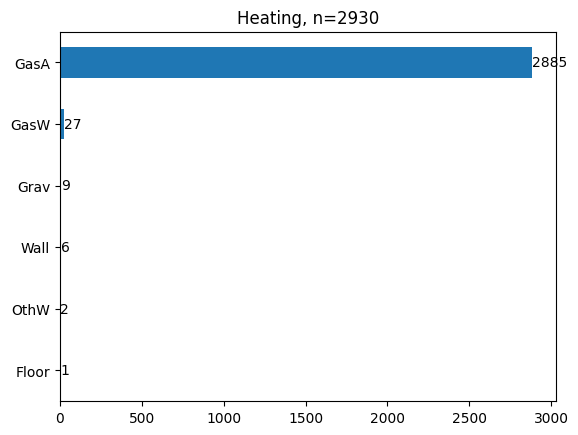

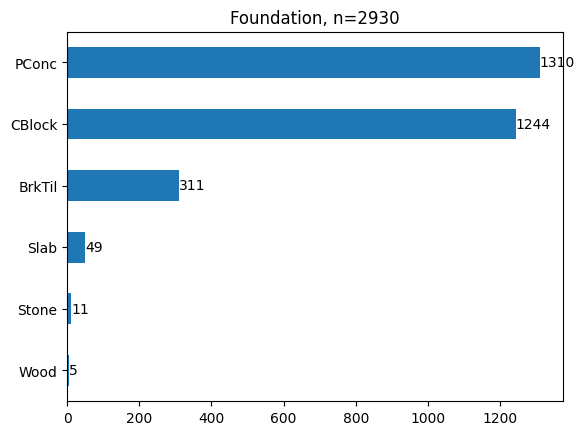

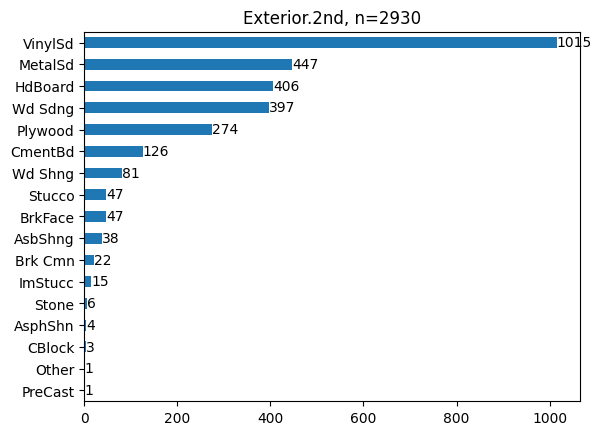

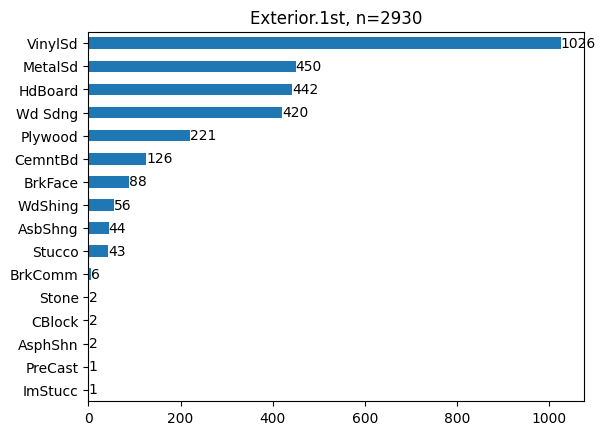

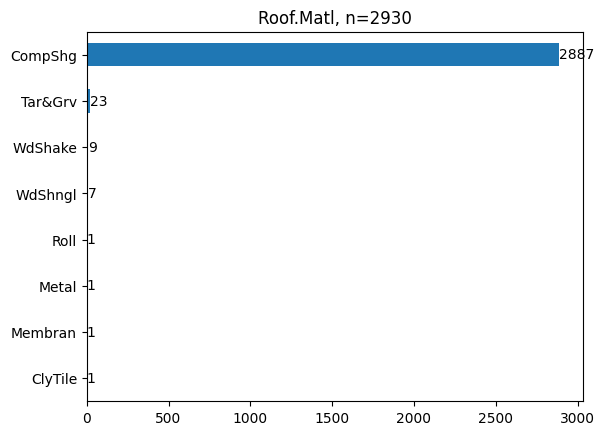

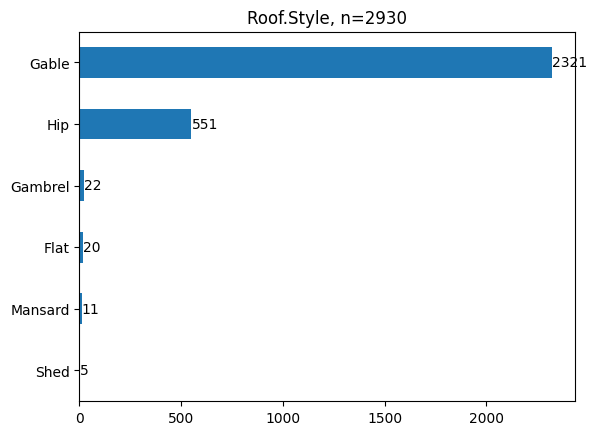

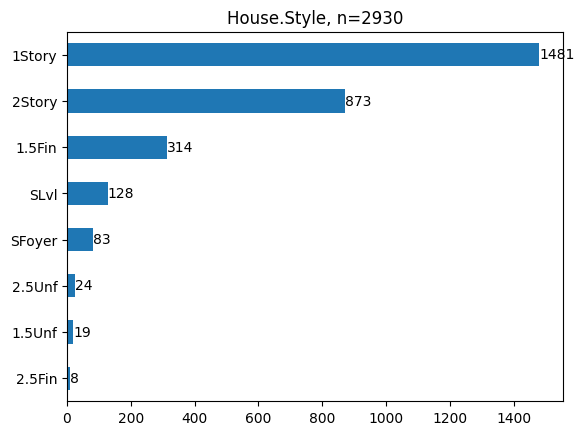

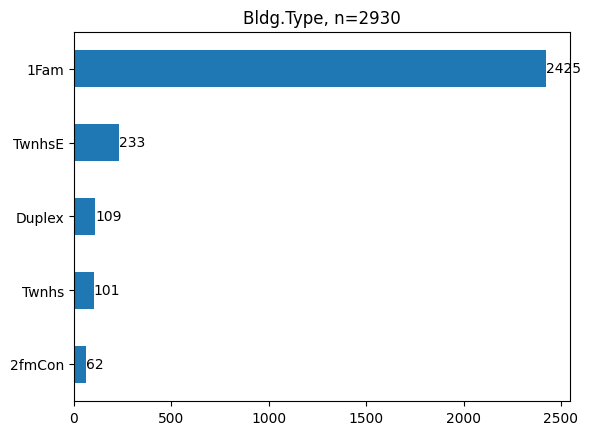

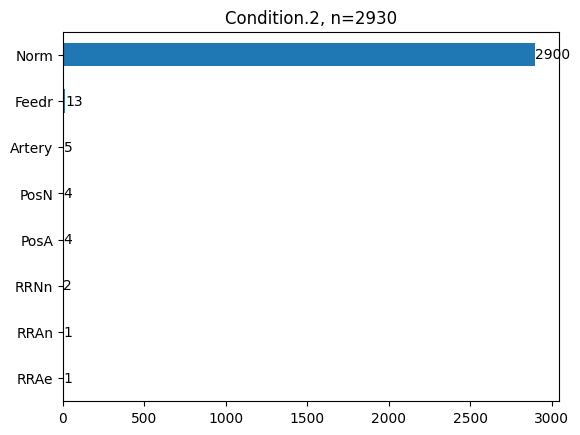

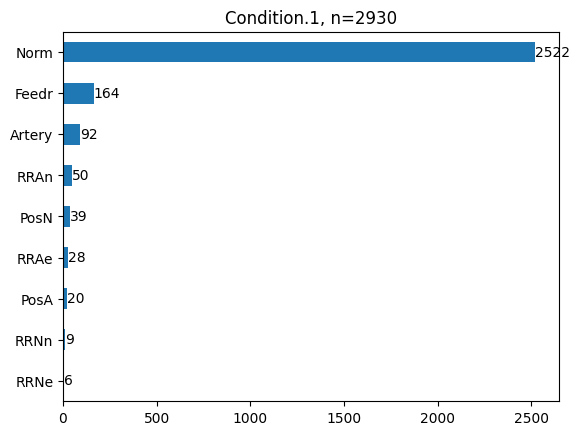

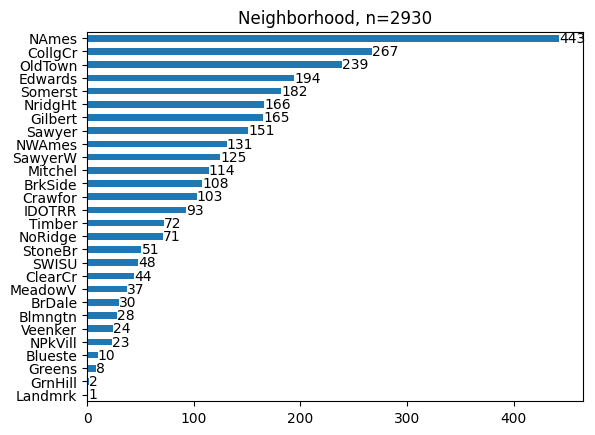

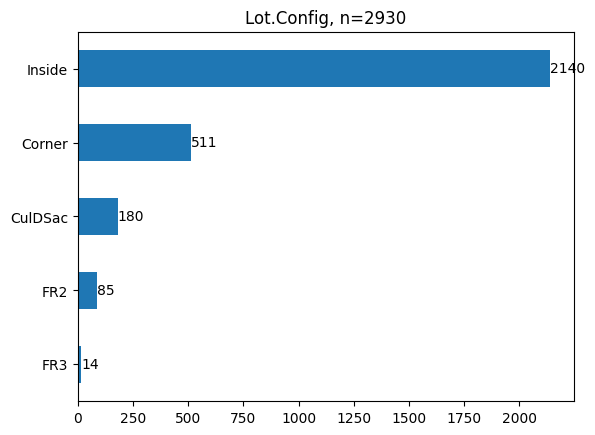

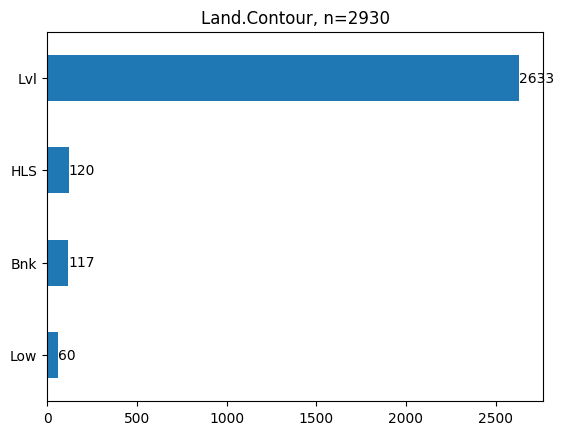

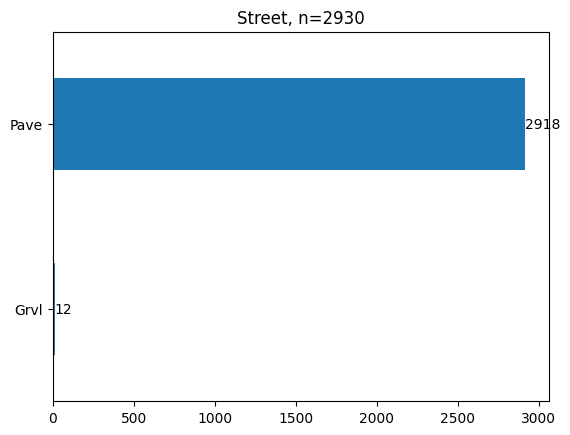

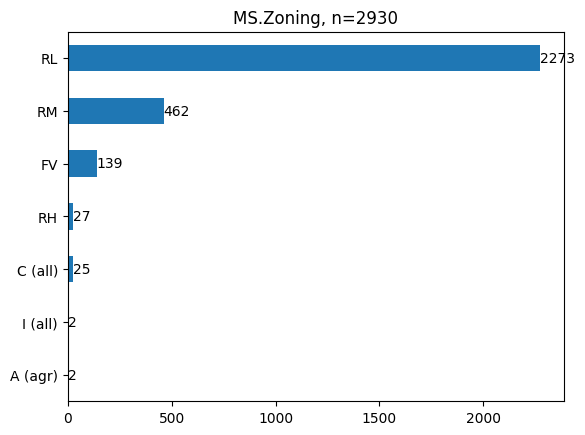

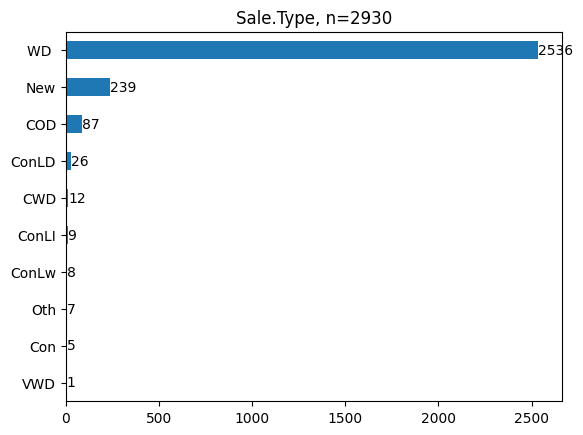

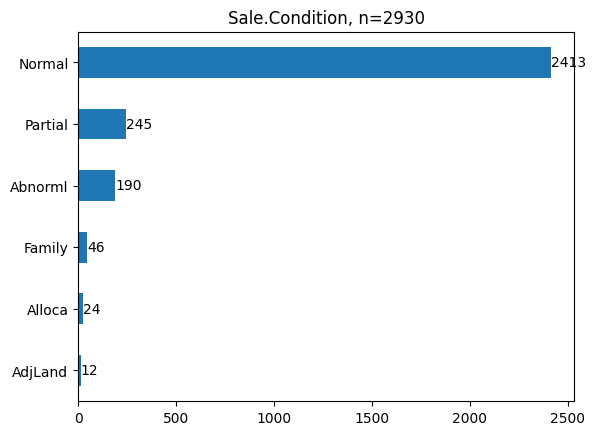

In [4]:
def plot_categoricals(data, cols):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        ax = data[col].value_counts().sort_values().plot.barh()
        for container in ax.containers:
            ax.bar_label(container)
        plt.title(f'{col}, n={int(val)}')
        plt.show()

plot_categoricals(data, categorical_variables)

It is important to notice:

- There are variables that have many categories with little representation. 
    - It may be interesting to remove the minor categories, and make a note that the model that we are developing is not suitable to process houses of these categories. 
    - Or we may decide to ignore columns of this nature altogether.
    - A third option is to group the minor categories into a new category named `Other`, to indicate that we are not ignoring these properties, but we don't have enough evidence to infer the effect of the precise minor categories into the sale price.
- Some variables contain a great number of missing values. 
    - It may be better to drop those columns,
    - or to assign all missing values to a newly created `Unknown` category



In order to simplify the data (CAREFUL: we may end up damaging the model here! If the future model is not performing well, it could be interesting to revisit these assumptions), we will process each variable, remove outliers, etc.

#### Residential zoning, sales types and conditions (`MS.Zoning`, `Sale.Type`, and `Sale.Condition`)

Lets concentrate first on residential sales types:

In [5]:
data['MS.Zoning'].unique()

['RL', 'RH', 'FV', 'RM', 'C (all)', 'I (all)', 'A (agr)']
Categories (7, object): ['A (agr)', 'C (all)', 'FV', 'I (all)', 'RH', 'RL', 'RM']

In [6]:
data['MS.Zoning'].value_counts()

RL         2273
RM          462
FV          139
RH           27
C (all)      25
A (agr)       2
I (all)       2
Name: MS.Zoning, dtype: int64

We observe that a small number of sales are for non-residential properties, namely the categories `C (all)`, `A (agr)`, and `I (all)`. Let's remove them.

In [7]:
selection = ~(data['MS.Zoning'].isin(['A (agr)', 'C (all)', 'I (all)']))
selection.value_counts()

True     2901
False      29
Name: MS.Zoning, dtype: int64

In [8]:
processed_data = data[selection].copy()

               count unique      top  freq
Misc.Feature     104      5     Shed    93
Alley            195      2     Grvl   119
Garage.Type     2754      6   Attchd  1729
Mas.Vnr.Type    2878      5     None  1723
MS.SubClass     2901     16       20  1074
Central.Air     2901      2        Y  2723
Heating         2901      6     GasA  2859
Foundation      2901      6    PConc  1308
Exterior.2nd    2901     17  VinylSd  1012
Exterior.1st    2901     16  VinylSd  1025
Roof.Matl       2901      8  CompShg  2858
Roof.Style      2901      6    Gable  2301
House.Style     2901      8   1Story  1467
Bldg.Type       2901      5     1Fam  2399
Condition.2     2901      8     Norm  2872
Condition.1     2901      9     Norm  2500
Neighborhood    2901     28    NAmes   443
Lot.Config      2901      5   Inside  2119
Land.Contour    2901      4      Lvl  2612
Street          2901      2     Pave  2895
MS.Zoning       2901      4       RL  2273
Sale.Type       2901     10      WD   2513
Sale.Condit

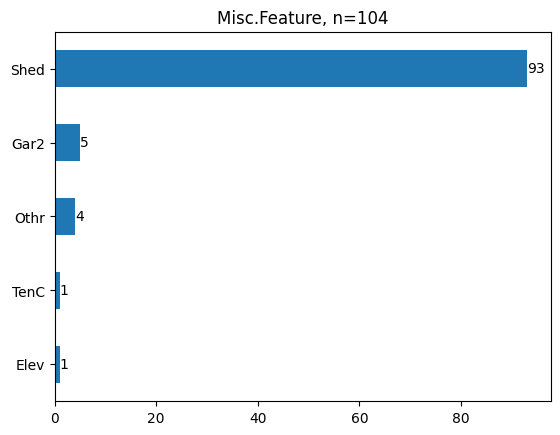

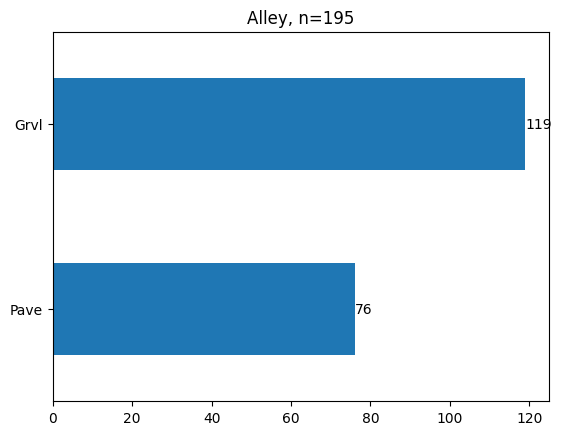

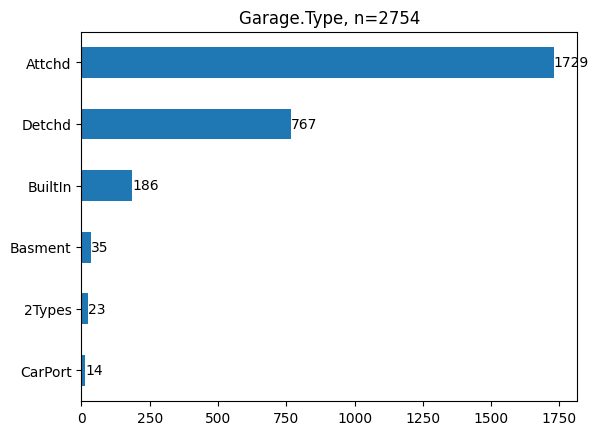

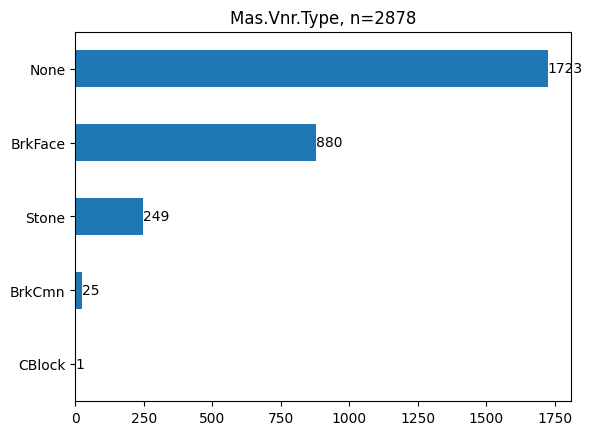

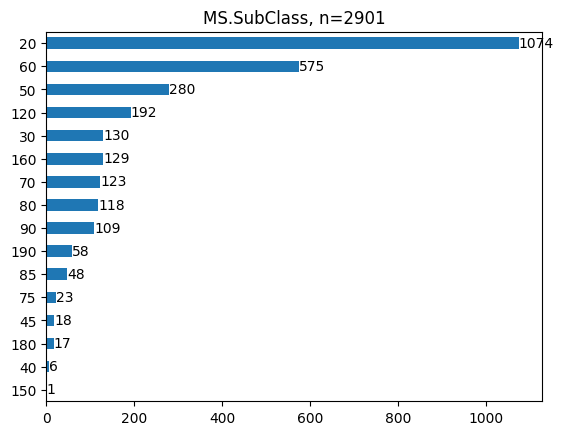

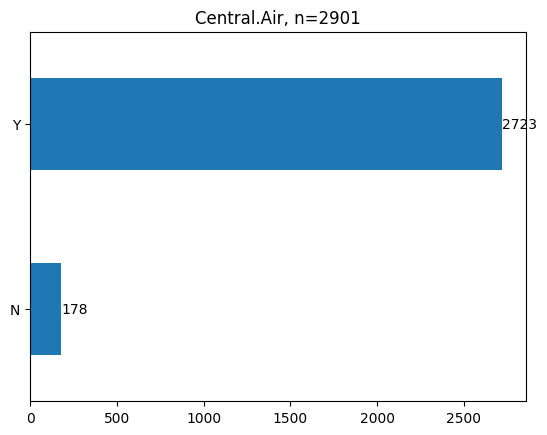

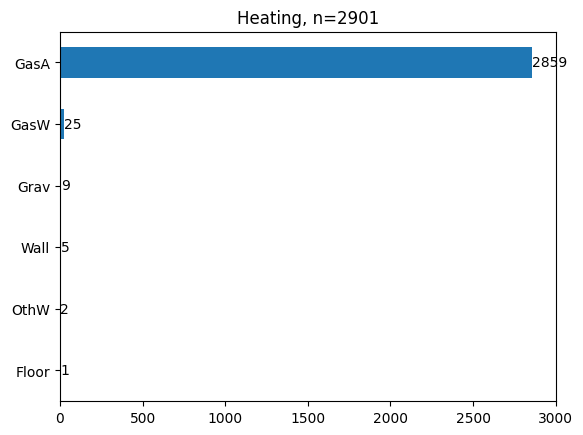

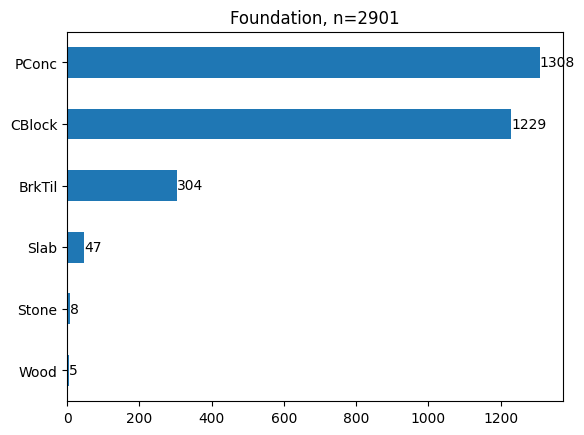

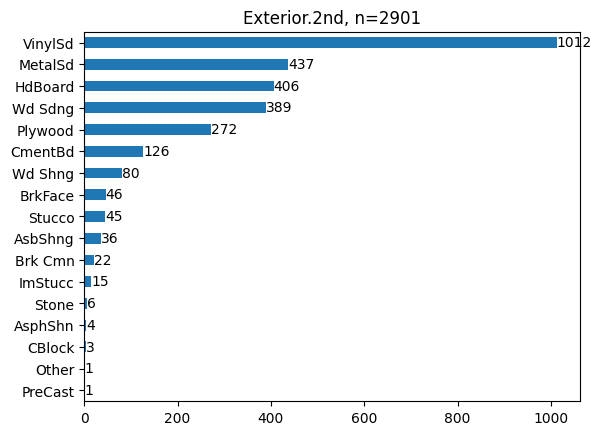

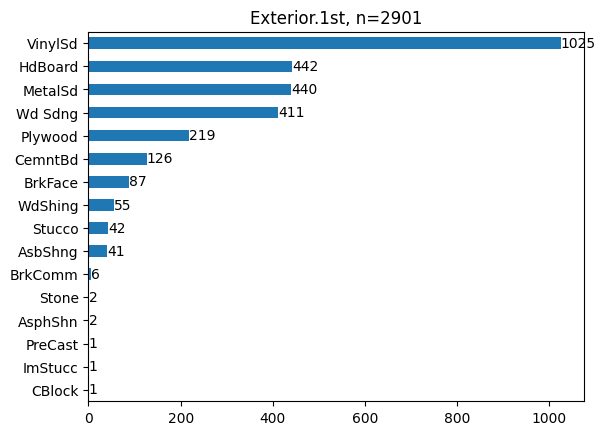

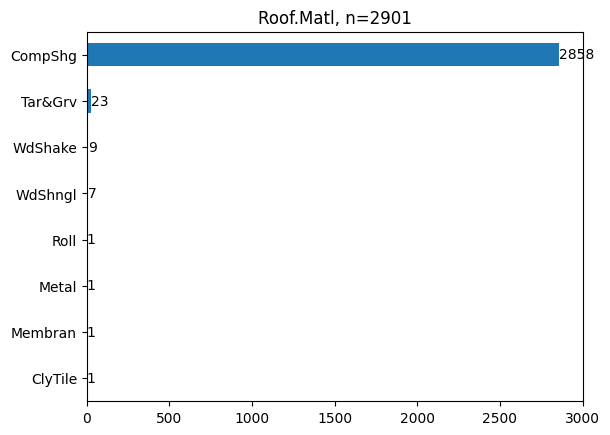

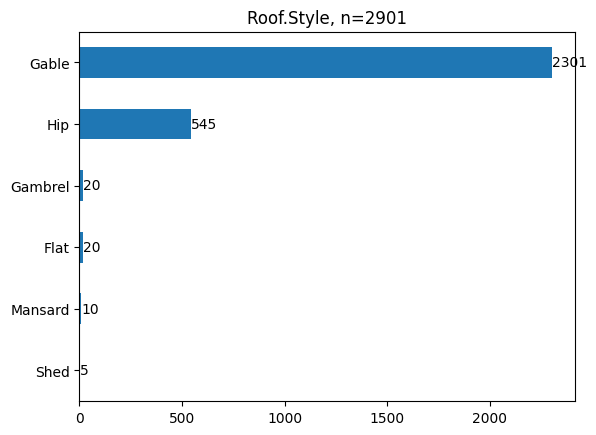

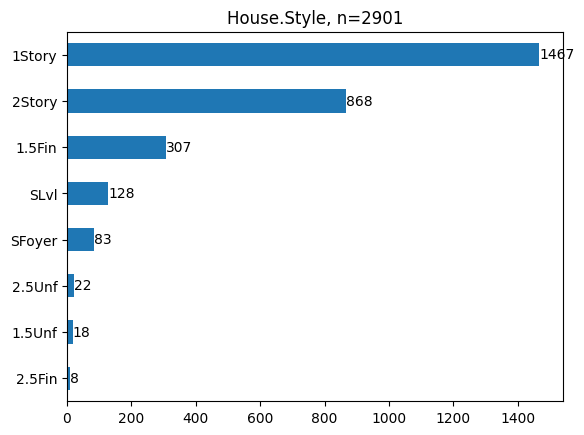

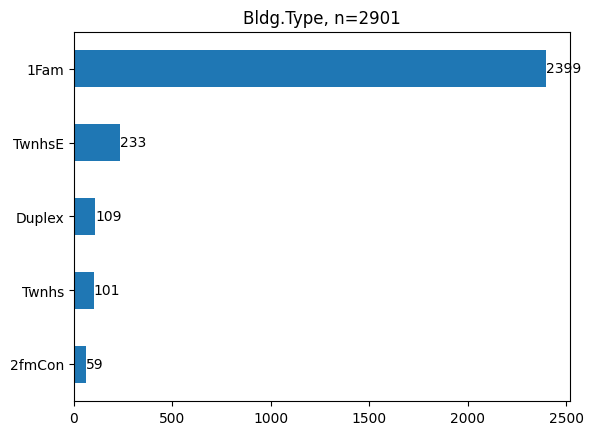

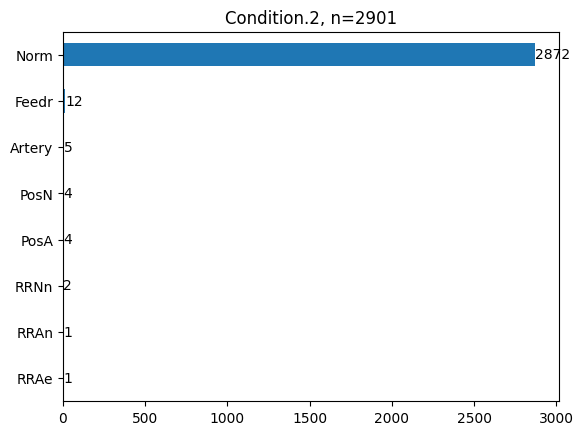

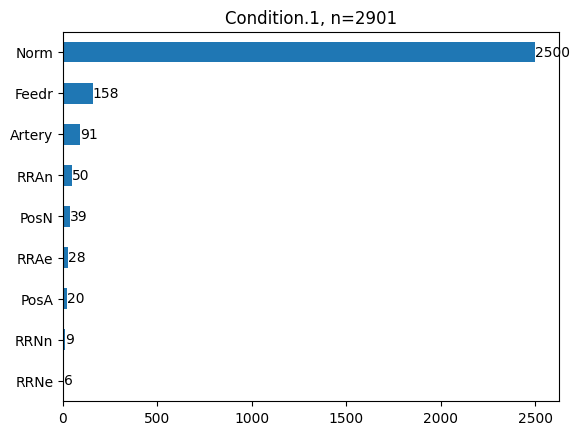

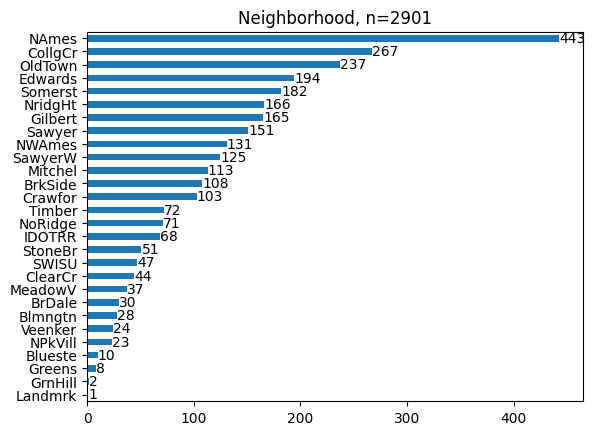

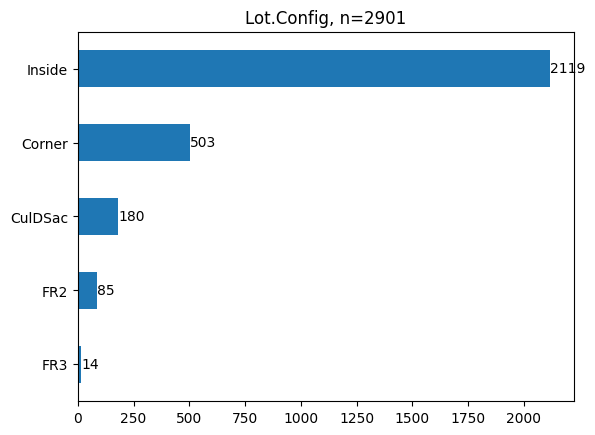

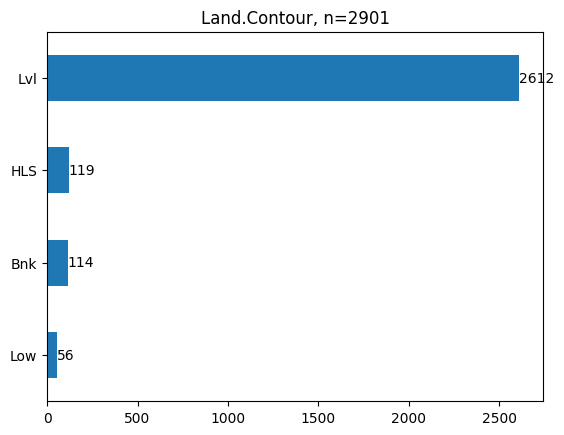

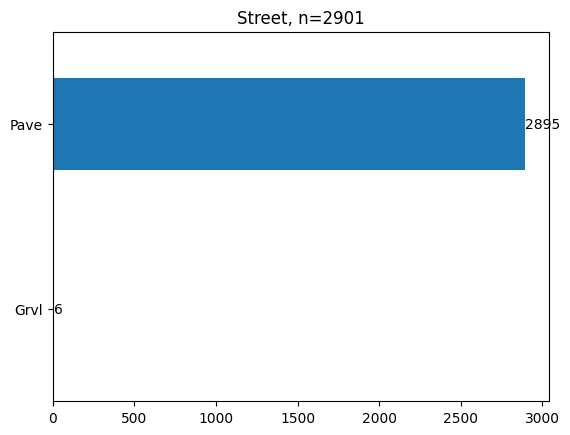

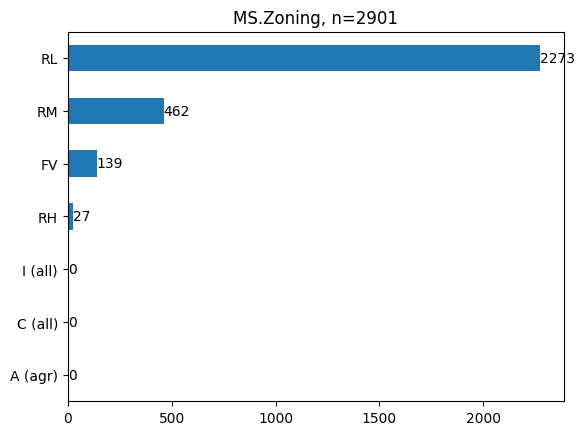

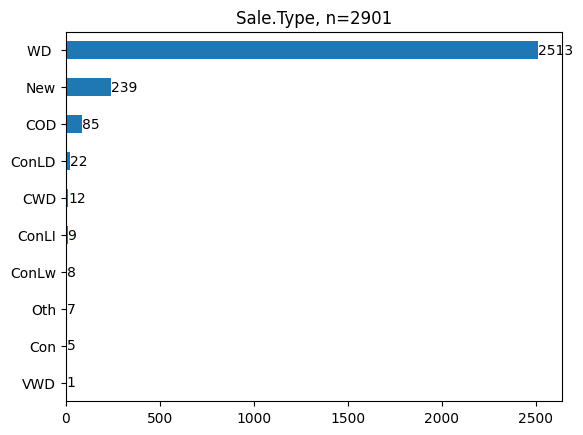

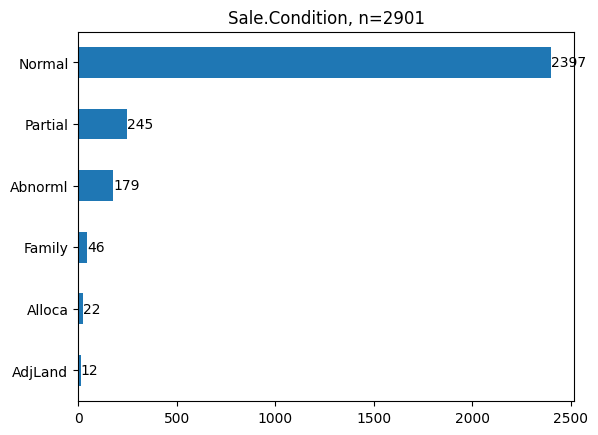

In [9]:
plot_categoricals(processed_data, categorical_variables)

So far, so good

In [10]:
data = processed_data

Lets analyze the types of sale and condition. The documentation states:

```
Sale Type (Nominal): Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		
Sale Condition (Nominal): Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
```

Lets look at the representation of each category in the dataset.

In [11]:
data['Sale.Type'].value_counts()

WD       2513
New       239
COD        85
ConLD      22
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: Sale.Type, dtype: int64

In [12]:
data['Sale.Type'].unique()

['WD ', 'New', 'COD', 'ConLI', 'Con', 'ConLD', 'Oth', 'ConLw', 'CWD', 'VWD']
Categories (10, object): ['COD', 'CWD', 'Con', 'ConLD', ..., 'New', 'Oth', 'VWD', 'WD ']

*AHA!* Careful with the name of the categories! The category `"WD "` has a space in it! Too many hours were spent debugging this kind of thing.

In [13]:
data['Sale.Condition'].value_counts()

Normal     2397
Partial     245
Abnorml     179
Family       46
Alloca       22
AdjLand      12
Name: Sale.Condition, dtype: int64

Upon careful analysis, looks like all types of sales and conditions are valid. But we need to be careful with the low representativity of some categories in both `Sale.Type` and `Sale.Condition`. Let's do some category reassigning:

- All warranty deed types will go into a `GroupedWD` category;
- Category `New` stays as-is.
- All the remaining minor categories go into an `Other` category.

In [14]:
processed_data = data.copy()

In [15]:
def remap_categories(
    series: pd.Series,
    old_categories: tuple[str],
    new_category: str,
) -> pd.Series:
    # Add the new category to the list of valid categories.
    series = series.cat.add_categories(new_category)

    # Set all items of the old categories as the new category.
    remapped_items = series.isin(old_categories)
    series.loc[remapped_items] = new_category

    # Clean up the list of categories, the old categories no longer exist.
    series = series.cat.remove_unused_categories()

    return series

In [16]:
processed_data['Sale.Type'] = remap_categories(
    series=processed_data['Sale.Type'],
    old_categories=('WD ', 'CWD', 'VWD'),
    new_category='GroupedWD',
)

processed_data['Sale.Type'] = remap_categories(
    series=processed_data['Sale.Type'],
    old_categories=('COD', 'ConLI', 'Con', 'ConLD', 'Oth', 'ConLw'),
    new_category='Other',
)

In [17]:
processed_data['Sale.Type'].value_counts()

GroupedWD    2526
New           239
Other         136
Name: Sale.Type, dtype: int64

Much better!

In [18]:
data = processed_data

#### Street paving (`Street`)

Now lets focus on street paving (`Street`):

In [19]:
data['Street'].value_counts()

Pave    2895
Grvl       6
Name: Street, dtype: int64

The very low representativity of the minor class `Grvl` forces us to ignore this column altogether:

In [20]:
data = data.drop(columns='Street')

#### House surroundings (`Condition.1` and `Condition.2`)

Let's check for conditions (`Condition.1` and `Condition.2`) pertaining to the house surroundings:

In [21]:
data['Condition.1'].value_counts()

Norm      2500
Feedr      158
Artery      91
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition.1, dtype: int64

In [22]:
data['Condition.2'].value_counts()

Norm      2872
Feedr       12
Artery       5
PosA         4
PosN         4
RRNn         2
RRAe         1
RRAn         1
Name: Condition.2, dtype: int64

In [23]:
pd.crosstab(data['Condition.1'], data['Condition.2'])

Condition.2,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNn
Condition.1,,,,,,,,
Artery,2,0,88,1,0,0,0,0
Feedr,1,3,150,0,0,1,1,2
Norm,0,0,2500,0,0,0,0,0
PosA,0,0,17,3,0,0,0,0
PosN,0,0,35,0,4,0,0,0
RRAe,0,0,28,0,0,0,0,0
RRAn,1,8,41,0,0,0,0,0
RRNe,0,0,6,0,0,0,0,0
RRNn,1,1,7,0,0,0,0,0


Again, we observe very low representation of the minor classes. Lets reassign some categories to group similar features:

- The railroad proximity categories (`RRAn`, `RRAe`, `RRNn`, and `RRNe`) will go into a single `Railroad` category;
- The `Feedr` and `Artery` categories refer to larger streets that collect traffic from local streets and connect neighborhoods (e.g. large avenues), lets place them into a `Roads` category;
- The `PosA` and `PosN` refer to positive features adjacent or nearby the building, lets place them into a `Positive` category.

In [24]:
processed_data = data.copy()

In [25]:
for col in ('Condition.1', 'Condition.2'):
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('RRAn', 'RRAe', 'RRNn', 'RRNe'),
        new_category='Railroad',
    )
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('Feedr', 'Artery'),
        new_category='Roads',
    )
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('PosA', 'PosN'),
        new_category='Positive',
    )

In [26]:
processed_data['Condition.1'].value_counts()

Norm        2500
Roads        249
Railroad      93
Positive      59
Name: Condition.1, dtype: int64

In [27]:
processed_data['Condition.2'].value_counts()

Norm        2872
Roads         17
Positive       8
Railroad       4
Name: Condition.2, dtype: int64

In [28]:
pd.crosstab(processed_data['Condition.1'], processed_data['Condition.2'])

Condition.2,Norm,Railroad,Roads,Positive
Condition.1,,,,
Norm,2500,0,0,0
Railroad,82,0,11,0
Roads,238,4,6,1
Positive,52,0,0,7


Looks like we can recombine the `Condition.1` and `Condition.2` columns into a single categorical column with the categories:

- `Norm`: `Condition.1` is `Norm`;
- `Railroad`: `Condition.1` is `Railroad` and `Condition.2` is `Norm`;
- `Roads`: `Condition.1` is `Roads` and `Condition.2` is not `Railroad`;
- `Positive`: `Condition.1` is `Positive`;
- `RoadsAndRailroad`: (`Condition.1` is `Railroad` and `Condition.2` is `Roads`) or (`Condition.1` is `Roads` and `Condition.2` is `Railroad`).

In [29]:
processed_data['Condition'] = pd.Series(
    index=processed_data.index,
    dtype=pd.CategoricalDtype(categories=(
        'Norm',
        'Railroad',
        'Roads',
        'Positive',
        'RoadsAndRailroad',
    )),
)

In [30]:
norm_items = processed_data['Condition.1'] == 'Norm'
processed_data['Condition'][norm_items] = 'Norm'

In [31]:
railroad_items = (processed_data['Condition.1'] == 'Railroad') \
    & (processed_data['Condition.2'] == 'Norm')
processed_data['Condition'][railroad_items] = 'Railroad'

In [32]:
roads_items = (processed_data['Condition.1'] == 'Roads') \
    & (processed_data['Condition.2'] != 'Railroad')
processed_data['Condition'][roads_items] = 'Roads'

In [33]:
positive_items = processed_data['Condition.1'] == 'Positive'
processed_data['Condition'][positive_items] = 'Positive'

In [34]:
roads_and_railroad_items = \
    ( \
        (processed_data['Condition.1'] == 'Railroad') \
        & (processed_data['Condition.2'] == 'Roads')
    ) \
    | ( \
        (processed_data['Condition.1'] == 'Roads') \
        & (processed_data['Condition.2'] == 'Railroad') \
    )
processed_data['Condition'][roads_and_railroad_items] = 'RoadsAndRailroad'

In [35]:
processed_data['Condition'].value_counts()

Norm                2500
Roads                245
Railroad              82
Positive              59
RoadsAndRailroad      15
Name: Condition, dtype: int64

There is no apparent need, for now, to go into further simplification of this variable. Lets drop the original variables:

In [36]:
processed_data = processed_data.drop(columns=['Condition.1', 'Condition.2'])

In [37]:
data = processed_data

#### Columns with many missing values (`Misc.Feature` and `Alley`)

The columns `Misc.Feature` and `Alley` are mostly formed by missing values!

             count unique   top freq
Misc.Feature   104      5  Shed   93
Alley          195      2  Grvl  119


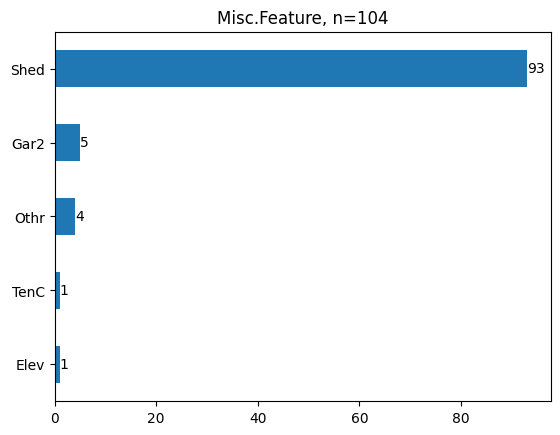

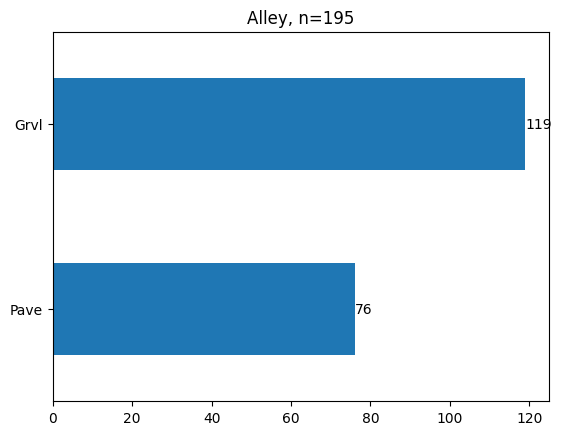

In [38]:
plot_categoricals(data, ['Misc.Feature', 'Alley'])

But it looks like we can reuse this information, still. We can transform the `Misc.Feature` variable into a `HasShed` variable that indicates whether the house has a shed:

In [39]:
data['HasShed'] = data['Misc.Feature'] == 'Shed'
data = data.drop(columns='Misc.Feature')

In [40]:
data['HasShed'].value_counts()

False    2808
True       93
Name: HasShed, dtype: int64

Likewise, we can mutate the `Alley` feature into a `HasAlley` feature:

In [41]:
data['HasAlley'] = ~data['Alley'].isna()
data = data.drop(columns='Alley')

In [42]:
data['HasAlley'].value_counts()

False    2706
True      195
Name: HasAlley, dtype: int64

#### Exterior coverings (`Exterior.1st` and `Exterior.2nd`)

The exterior coverings have a lot of categories, some with very low representativity:

             count unique      top  freq
Exterior.1st  2901     16  VinylSd  1025
Exterior.2nd  2901     17  VinylSd  1012


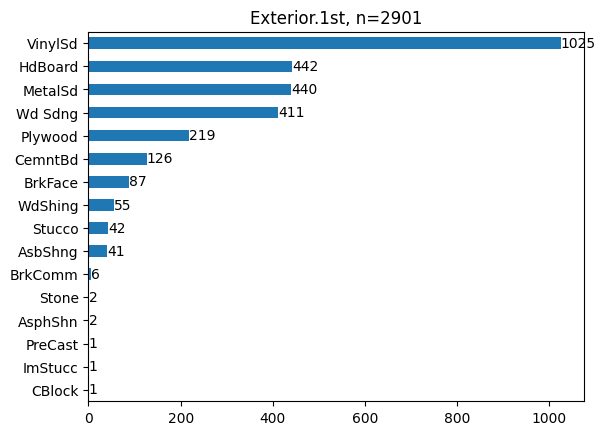

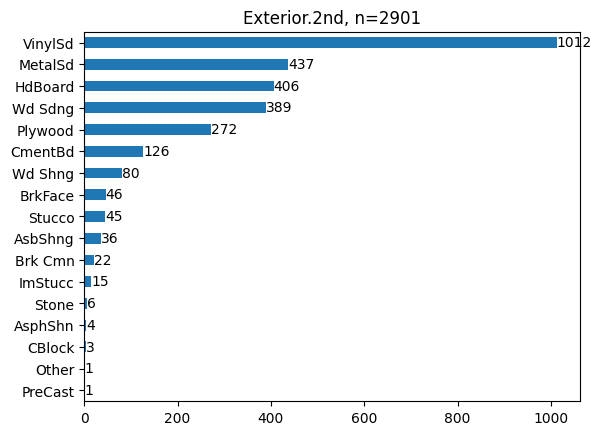

In [43]:
plot_categoricals(data, ['Exterior.1st', 'Exterior.2nd'])

Also, it looks like there are a few typos!


| `Exterior.1st` | `Exterior.2nd` | `Correct value` |
|----------------|----------------|-----------------|
| `BrkComm`      | `Brk Cmn`      | `BrkComm`       |
| `CemntBd`      | `CmentBd`      | `CemntBd`       |
| `WdShing`      | `Wd Shng`      | `WdShing`       |

Lets fix those

In [44]:
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('Brk Cmn', ),
    new_category='BrkComm',
)
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('CmentBd', ),
    new_category='CemntBd',
)
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('Wd Shng', ),
    new_category='WdShing',
)


In [45]:
for col in ('Exterior.1st', 'Exterior.2nd'):
    categories = data[col].cat.categories
    data[col] = data[col].cat.reorder_categories(sorted(categories))

In [46]:
pd.crosstab(data['Exterior.1st'], data['Exterior.2nd'])

Exterior.2nd,AsbShng,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Other,Plywood,PreCast,Stone,Stucco,VinylSd,Wd Sdng,WdShing
Exterior.1st,,,,,,,,,,,,,,,,,
AsbShng,33,0,0,0,0,1,0,0,0,0,5,0,0,1,0,1,0
AsphShn,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BrkComm,0,0,4,0,0,0,0,0,0,0,0,0,0,1,0,1,0
BrkFace,1,0,0,43,0,0,3,0,3,0,8,0,3,3,1,21,1
CBlock,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
CemntBd,0,0,0,0,0,124,0,0,0,0,0,0,0,0,0,1,1
HdBoard,0,1,0,1,0,0,383,6,1,0,41,0,0,1,0,3,5
ImStucc,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
MetalSd,0,1,0,0,1,0,3,0,427,0,0,0,0,3,2,2,1


It looks like there are a few popular options and lots of poorly represented materials beyond the popular ones. Due to lack of representativity, lets keep only the popular categories as-is, and group the rest into an `Other` category.

Also, looks like it is often the case that the first material is the same as the second material, probably to indicate that the house exterior contains only one material. Therefore, we will keep only the `Exterior.1st` variable.

In [47]:
processed_data = data.copy()

In [48]:
processed_data['Exterior.1st'].value_counts()

VinylSd    1025
HdBoard     442
MetalSd     440
Wd Sdng     411
Plywood     219
CemntBd     126
BrkFace      87
WdShing      55
Stucco       42
AsbShng      41
BrkComm       6
AsphShn       2
Stone         2
CBlock        1
ImStucc       1
PreCast       1
Name: Exterior.1st, dtype: int64

In [49]:
mat_count = processed_data['Exterior.1st'].value_counts()
mat_count

VinylSd    1025
HdBoard     442
MetalSd     440
Wd Sdng     411
Plywood     219
CemntBd     126
BrkFace      87
WdShing      55
Stucco       42
AsbShng      41
BrkComm       6
AsphShn       2
Stone         2
CBlock        1
ImStucc       1
PreCast       1
Name: Exterior.1st, dtype: int64

In [50]:
rare_materials = list(mat_count[mat_count < 40].index)
rare_materials

['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc', 'PreCast']

In [51]:
processed_data['Exterior'] = remap_categories(
    series=processed_data['Exterior.1st'],
    old_categories=rare_materials,
    new_category='Other',
)
processed_data = processed_data.drop(columns=['Exterior.1st', 'Exterior.2nd'])

In [52]:
processed_data['Exterior'].value_counts()

VinylSd    1025
HdBoard     442
MetalSd     440
Wd Sdng     411
Plywood     219
CemntBd     126
BrkFace      87
WdShing      55
Stucco       42
AsbShng      41
Other        13
Name: Exterior, dtype: int64

In [53]:
data = processed_data

#### `Heating`

        count unique   top  freq
Heating  2901      6  GasA  2859


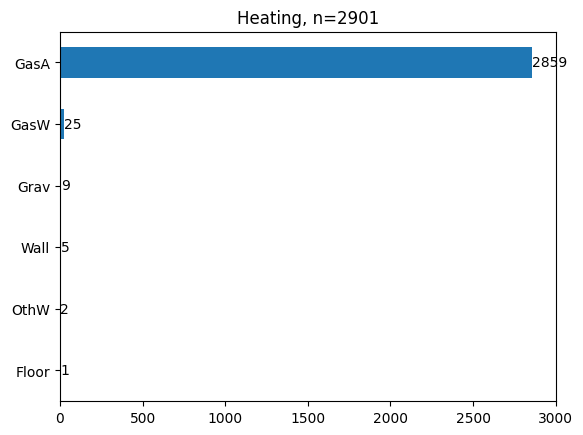

In [55]:
plot_categoricals(data, ['Heating',])

This column does not have missing values, and an overwhelming amount of items belong to the same category. As such, there is not much information here, lets discard the column.

In [56]:
data = data.drop(columns='Heating')

#### `Roof.Matl` and `Roof.Style`

           count unique      top  freq
Roof.Matl   2901      8  CompShg  2858
Roof.Style  2901      6    Gable  2301


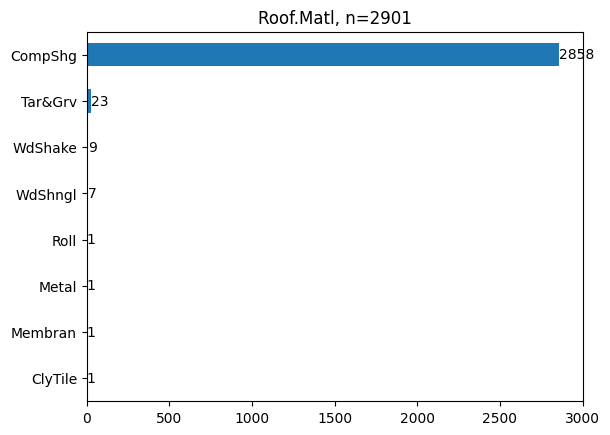

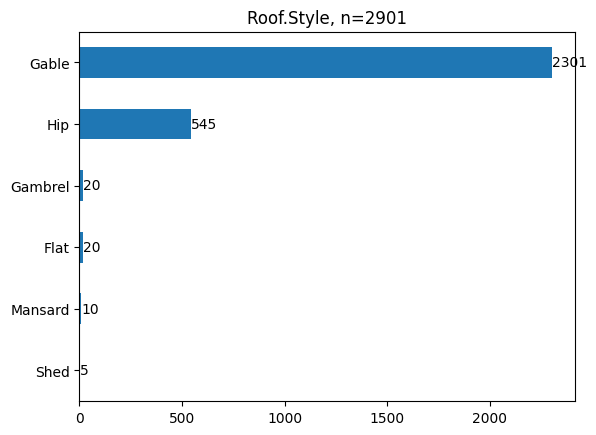

In [57]:
plot_categoricals(data, ['Roof.Matl', 'Roof.Style'])

Due to the low representativity of the minor categories in the `Roof.Matl` feature, we will drop it.

In [58]:
data = data.drop(columns='Roof.Matl')

In the `Roof.Style` feature we have two substantial categories, and a few very minor ones. Lets group the minor categories into an `Other` category:

In [61]:
data['Roof.Style'] = remap_categories(
    series=data['Roof.Style'],
    old_categories=[
        'Flat',
        'Gambrel',
        'Mansard',
        'Shed',
    ],
    new_category='Other',
)

In [62]:
data['Roof.Style'].value_counts()

Gable    2301
Hip       545
Other      55
Name: Roof.Style, dtype: int64

### Analyzing the continuous variables